# Get ice hockey odds data 

This script collects historic sports betting data for swedish ice hockey matches. 
Source is the statistics web page of the state-owned gambling company in Sweden, "Svenska Spel". 

The script loops over a range of dates and extract data from the home page. 


## Webpage to scrape

The datasource is www.liverattning.se, looking like below. 
https://liverattning.se/statistik/1x2/2019-09-04/powerplay looks like below.

* Result -> Result
* Tecken -> Sign
* Spelad % -> Distribution of placed bets for the game
* Rank -> The rank of all placed bets for all games in the round (Rank = 1 -> sign was most played in this round)
* Odds -> The odds for outcome of the game

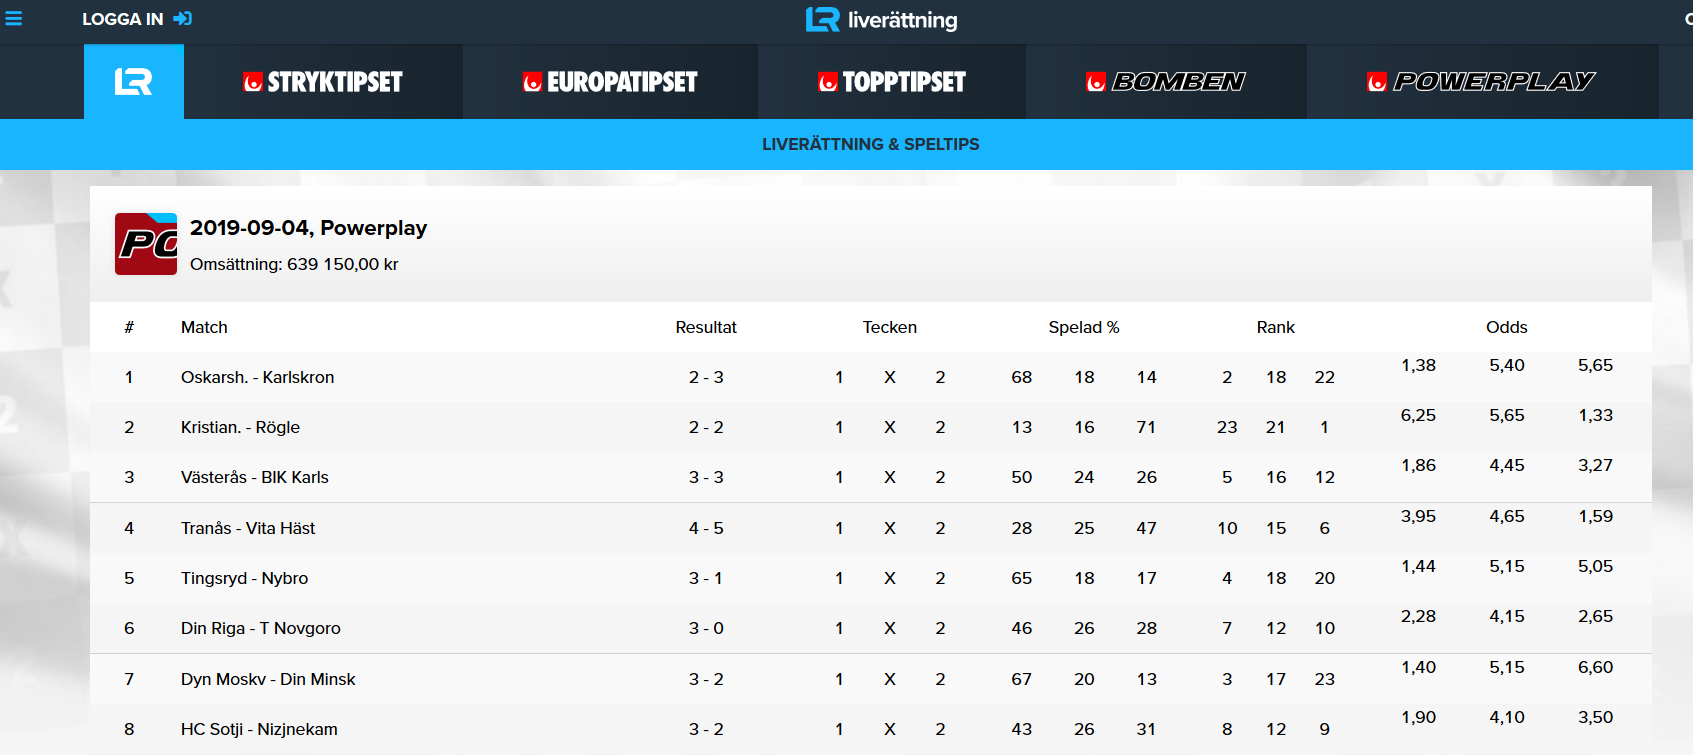

 Data is structured in a table, and thus data can be extracted with the pandas function 
 ```pd.read_html()```, which extracts data in ```<td></td>``` tags
 
 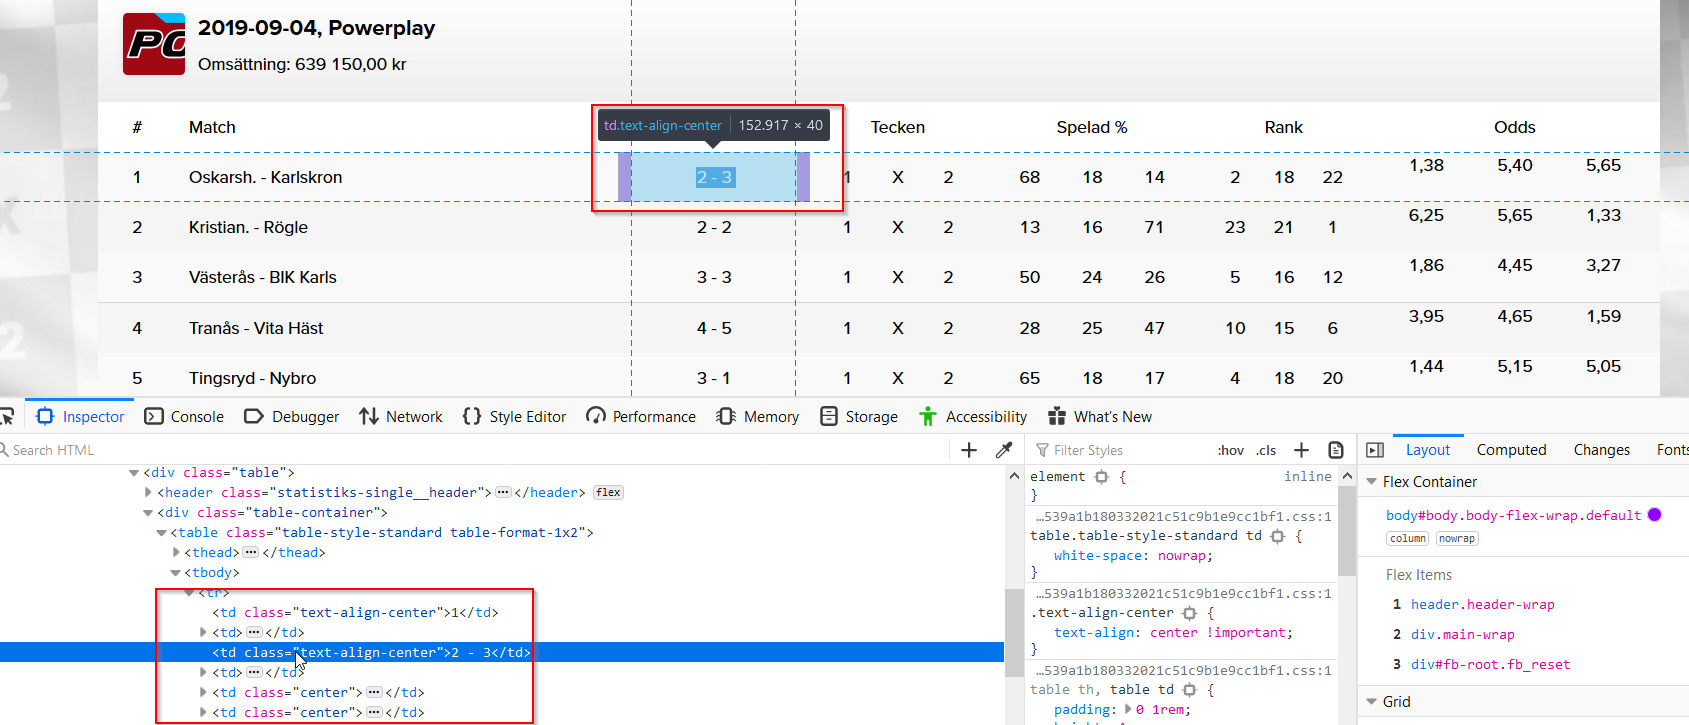

## Code to extract data

The approach will be: 
1. Determine what table needs to be extracted from the webpage
2. Loop over all dates and merge into one dataframe
3. Clean data

Packages what will be used are pretty Let's start coding by importing relevant packages. 

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from datetime import timedelta

import re

from urllib.error import HTTPError

Before setting up the loop, it must be defined what table that should be extracted. There might be multiple tables in the url, and the data to avoid importing too much data it is a good idea to identify and extract only the table containing the relevant data. 

In [2]:
url_test = "https://liverattning.se/statistik/1x2/2019-09-04/powerplay"

urldata = pd.read_html(url_test)

print("Number of tables: " + str(len(urldata)))

Number of tables: 4


In [3]:
# Get data for all tables, print the first table
tbl_1=pd.read_html(url_test)[0]
tbl_2=pd.read_html(url_test)[1]
tbl_3=pd.read_html(url_test)[2]
tbl_4=pd.read_html(url_test)[3]

tbl_1.head(n=10)

,#,Match,Resultat,Tecken,Spelad %,Rank,Odds
0,1,Oskarsh. - Karlskron,2 - 3,1 X 2,68 18 14,2 18 22,"1,38 5,40 5,65"
1,2,Kristian. - Rögle,2 - 2,1 X 2,13 16 71,23 21 1,"6,25 5,65 1,33"
2,3,Västerås - BIK Karls,3 - 3,1 X 2,50 24 26,5 16 12,"1,86 4,45 3,27"
3,4,Tranås - Vita Häst,4 - 5,1 X 2,28 25 47,10 15 6,"3,95 4,65 1,59"
4,5,Tingsryd - Nybro,3 - 1,1 X 2,65 18 17,4 18 20,"1,44 5,15 5,05"
5,6,Din Riga - T Novgoro,3 - 0,1 X 2,46 26 28,7 12 10,"2,28 4,15 2,65"
6,7,Dyn Moskv - Din Minsk,3 - 2,1 X 2,67 20 13,3 17 23,"1,40 5,15 6,60"
7,8,HC Sotji - Nizjnekam,3 - 2,1 X 2,43 26 31,8 12 9,"1,90 4,10 3,50"


The relevant data is in table with index 0, so this one will be extracted.

#### Looping over dates and collecting data

Time to set up the loop over dates and collect all data. 

In [4]:
# Set start and stop data
start_date = "2019-09-01"
stop_date = "2020-04-10"

# Convert to datetime values
start = datetime.strptime(start_date, "%Y-%m-%d")
stop = datetime.strptime(stop_date, "%Y-%m-%d")

# Initiate empty list
htmldata = []
error_dates = []

# Loop over range of date, extracting table with index 0
while start < stop:   
    url = "https://liverattning.se/statistik/1x2/" + str(start.date()) + "/powerplay"
    try:
        htmldata.append(pd.read_html(url)[0].assign(date=start.date()))        
    except HTTPError:
        error_dates.append(url)
        
    start = start + timedelta(days=1)  # increment by one day
   


In [5]:
# Turn list into dataframe
df=pd.concat(htmldata)
print("Number of rows: " + str(df.shape[0]))
df.head()


Number of rows: 1528


,#,Match,Resultat,Tecken,Spelad %,Rank,Odds,date
0,1,Skelleft. - Grenoble,1 - 2,1 X 2,81 13 6,1 21 24,"1,13 8,50 12,70",2019-09-01
1,2,Frölunda - HC Mountf,2 - 3,1 X 2,76 16 8,2 19 23,"1,34 5,70 6,25",2019-09-01
2,3,Vienna - Djurgård.,1 - 2,1 X 2,24 24 52,15 15 5,"4,40 5,45 1,49",2019-09-01
3,4,GKS Tychy - Mannheim,2 - 2,1 X 2,11 14 75,22 20 3,"10,50 7,60 1,17",2019-09-01
4,5,Card Devi - EC Graz,3 - 3,1 X 2,31 27 42,9 12 8,"2,85 4,45 1,99",2019-09-01


### Data cleaning

Output above looks nice, but there is some cleaning to do before it can be used for further analysis. 

#### Separate columns

In [86]:
# Drop not needed columns
df_games = df.drop(['#', 'Tecken', 'Rank'], axis=1)
df_games.columns = df_games.columns.str.replace(' %', '')

# Remove eventual consecutive spaces
df_games.Spelad = df_games.Spelad.str.replace(' +', ' ') 
df_games.Odds = df_games.Odds.str.replace(' +', ' ') 

df_games.head()

,Match,Resultat,Spelad,Odds,date
0,Skelleft. - Grenoble,1 - 2,81 13 6,"1,13 8,50 12,70",2019-09-01
1,Frölunda - HC Mountf,2 - 3,76 16 8,"1,34 5,70 6,25",2019-09-01
2,Vienna - Djurgård.,1 - 2,24 24 52,"4,40 5,45 1,49",2019-09-01
3,GKS Tychy - Mannheim,2 - 2,11 14 75,"10,50 7,60 1,17",2019-09-01
4,Card Devi - EC Graz,3 - 3,31 27 42,"2,85 4,45 1,99",2019-09-01


The columns ```Match```, ```Resultat```, ```Spelad``` and ```Odds``` has to be separated. 

In [87]:
# Split columns
df_games[['home', 'away']] = df_games.Match.str.split('-', expand = True, n=1)
df_games[['score_home', 'score_away']] = df_games.Resultat.str.split('-', expand = True, n=1)
df_games[['played_1', 'played_X', 'played_2']] = df_games.Spelad.str.split(' ', expand = True, n=2)
df_games[['odds_1', 'odds_X', 'odds_2']] = df_games.Odds.str.split(' ', expand = True, n=2)

# Strip the string columns
df_obj = df_games.select_dtypes(['string'])
df_games[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

df_games= df_games.drop(['Spelad', 'Odds'], axis=1)
df_games.head()

,Match,Resultat,date,home,away,score_home,score_away,played_1,played_X,played_2,odds_1,odds_X,odds_2
0,Skelleft. - Grenoble,1 - 2,2019-09-01,Skelleft.,Grenoble,1,2,81,13,6,"1,13","8,50","12,70"
1,Frölunda - HC Mountf,2 - 3,2019-09-01,Frölunda,HC Mountf,2,3,76,16,8,"1,34","5,70","6,25"
2,Vienna - Djurgård.,1 - 2,2019-09-01,Vienna,Djurgård.,1,2,24,24,52,"4,40","5,45","1,49"
3,GKS Tychy - Mannheim,2 - 2,2019-09-01,GKS Tychy,Mannheim,2,2,11,14,75,"10,50","7,60","1,17"
4,Card Devi - EC Graz,3 - 3,2019-09-01,Card Devi,EC Graz,3,3,31,27,42,"2,85","4,45","1,99"


#### Clean up team names by fuzzy matching

Next step is to check the team names. It seems some of them are abbreviated, so to be on the safe side, this should be checked. For example , the team Djurgården has been written in several ways. 

In [88]:
df_games[df_games['home'].str.contains('Djurg')].head()

,Match,Resultat,date,home,away,score_home,score_away,played_1,played_X,played_2,odds_1,odds_X,odds_2
6,Djurgård. - Vienna,3 - 6,2019-09-06,Djurgård.,Vienna,3,6,79,13,8,"1,28","6,40","7,00"
6,Djurgård. - Linköping,4 - 2,2019-09-14,Djurgård.,Linköping,4,2,68,17,15,"1,81","4,45","3,85"
7,Djurgården - Linköping,0 - 0,2019-09-14,Djurgården,Linköping,0,0,32,44,24,NaN,NaN,NaN
0,Djurgård. - Örebro,4 - 2,2019-09-19,Djurgård.,Örebro,4,2,61,20,19,"1,76","4,50","4,05"
0,Djurgård. - HV71,1 - 1,2019-09-26,Djurgård.,HV71,1,1,61,21,18,"1,78","4,40","4,00"


The inconsistant naming has to be adjusted, which will be handled  by using the ```fuzzywuzzy``` package. This packages uses the Levenshtein Distance to calculate the differences between sequences in strings. 

In [89]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Partial ratio uses the shortest string for matching -> thus higher fuzz_ratio
print("fuzz.ratio " + str(fuzz.ratio("Djurgården", "Djurgård.")))
print("fuzz.partial_ratio " + str(fuzz.partial_ratio("Djurgården", "Djurgård.")))

fuzz.ratio 84
fuzz.partial_ratio 89


I have prepared a dataset with cleaned teamnames, which is imported and used as the "master"-name.

In [90]:
import os
notebook_path = os.path.abspath("get_odds_liverattning.ipynb")
df_teamnames = pd.read_csv(os.path.join(os.path.dirname(notebook_path),"data/teamnames.csv"), encoding= 'unicode_escape')

# Turn dataframe into series
teams = df_teamnames.iloc[:,0]

teams.head()

0       Frölunda HC
1    Skellefteå AIK
2       Leksands IF
3    Djurgårdens IF
4      Färjestad BK
Name: teams, dtype: object

Let's set up a function that matches input to string to all teamnames, and outputs the max value.
The function also includes a threshold value for the matching, to ensure it doesnt return any unlogical matches. 

In [91]:
def get_max_fuzz(string, teamnames, fuzz_threshold):
    
    fuzz_value = 0
    # Loop over all names in the master-teamnames
    for index, teamname in enumerate(teamnames):
        if fuzz.partial_ratio(string, teamnames[index])>fuzz_value:
            fuzz_value=fuzz.partial_ratio(string.lower(), teamnames[index].lower())
            fuzz_team = teamnames[index]
        
    if fuzz_value > fuzz_threshold:
        return fuzz_team
    else:
        return string

In [92]:
# Some examples
print(get_max_fuzz("test1234", teams,60))
print(get_max_fuzz("Oskarsh", teams,60))
print(get_max_fuzz("Djurg.", teams,60))
print(get_max_fuzz("Väst.", teams,60))

test1234
IK Oskarshamn
Djurgårdens IF
Västerås IK


Applying this function to our dataset will give us the matching values. 
I use 70 as threshold, as this will return values which are pretty similar. 

In [93]:
df_games['home_fuzzmatch'] = df_games.apply(lambda x: get_max_fuzz(x.home, teams, 70), axis=1)
df_games['away_fuzzmatch'] = df_games.apply(lambda x: get_max_fuzz(x.away, teams, 70), axis=1)


df_games[['home', 'home_fuzzmatch']].head(n=10)

,home,home_fuzzmatch
0,Skelleft.,Skellefteå AIK
1,Frölunda,Frölunda HC
2,Vienna,Vienna
3,GKS Tychy,GKS Tychy
4,Card Devi,Card Devi
5,Pelicans,Pelicans
6,Kärpät,Kärpät
7,Örebro,Örebro HK
0,Oskarsh.,IK Oskarshamn
1,Kristian.,Kristianstads IK


#### Last cleanup and 

In the last step will be to drop some columns and add new ones that will be good to have when analyzing the data. 

In [94]:
df_games= df_games.drop(['home', 'away'], axis=1)
df_games = df_games.rename(columns={"home_fuzzmatch": "home", "away_fuzzmatch": "away"})

# Remove rows without score
df_games = df_games[df_games['score_home']!='']

# Define outcome result
df_games['outcome'] = "1"
df_games.loc[df_games['score_home'].astype(float)==df_games['score_away'].astype(float),'outcome'] = "X"
df_games.loc[df_games['score_home'].astype(float)<df_games['score_away'].astype(float),'outcome'] = "2"

#Define outcome odds
df_games['odds_outcome'] = df_games.apply(lambda row: row['odds_1'] if row['outcome'] == '1' else
                                            (row['odds_X'] if row['outcome'] == 'X' else
                                             (row['odds_2'] if row['outcome'] == '2' else row)), axis=1)

df_games.head()

,Match,Resultat,date,score_home,score_away,played_1,played_X,played_2,odds_1,odds_X,odds_2,home,away,outcome,odds_outcome
0,Skelleft. - Grenoble,1 - 2,2019-09-01,1,2,81,13,6,"1,13","8,50","12,70",Skellefteå AIK,Grenoble,2,"12,70"
1,Frölunda - HC Mountf,2 - 3,2019-09-01,2,3,76,16,8,"1,34","5,70","6,25",Frölunda HC,HC Mountf,2,"6,25"
2,Vienna - Djurgård.,1 - 2,2019-09-01,1,2,24,24,52,"4,40","5,45","1,49",Vienna,Djurgårdens IF,2,"1,49"
3,GKS Tychy - Mannheim,2 - 2,2019-09-01,2,2,11,14,75,"10,50","7,60","1,17",GKS Tychy,Mannheim,X,"7,60"
4,Card Devi - EC Graz,3 - 3,2019-09-01,3,3,31,27,42,"2,85","4,45","1,99",Card Devi,EC Graz,X,"4,45"


In [96]:
df_games.to_csv("data/sweden_odds.csv", index=False)